# Making a linear interpolation for the dispersion relationship.

Refractive index from:

http://refractiveindex.info/?shelf=main&book=LiNbO3&page=Zelmon-o

Let's start with 3-wave mixing interactions. 

The conditions we need are:
\begin{align}
&T \left|\omega_1+\omega_2+\omega_3 \right| \le \epsilon_1\\
&\left| L\left(k_1+k_2+k_3\right) \right|= \le \epsilon_2 \implies \left| \frac{L}{c} \left( n(\omega_1)\omega_1+n(\omega_2)\omega_2+n(\omega_3)\omega_3 \right)) \right| \le \epsilon_2.
\end{align}
In practice we use small cutoffs $\epsilon_1,\epsilon_2$ instead of zeros. These are dimensionless numbers. The $T$ is the duration of the simulation or decay time of the system modes (whichever is smaller), and $\epsilon_1$ maps to the fractional error in the result. $L$ is the legnth of the cavity, and $\epsilon_2$ is chosen so that $L \Delta k / 2$  is sufficiently small so that that $\text{sinc}^2(L \Delta_k /2)$ is small ($L \Delta k / 2$ should be on the order of magnitude of 10).

One way to solve a set of equations is to use Newton's method a few times. We do this here to simulateneously solve the phase and frequency matching conditions for $\chi^{(2)}$ nonlinearity.
The main idea is to trace along the solutions, incrementing $\omega_1$ at each step and finding the new $\omega_2$ and $\omega_3$ at each step.

Another point of consideration when considering the cutoffs $\epsilon_1$ and $\epsilon_2$ is the number of modes being dropped. If this number if very large the approximation is not guaranteed to work well.

Later I also interpolate the dispersion relations in the appropriate region. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import scipy.constants

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sympy as sp
from sympy.utilities.autowrap import ufuncify

In [113]:
from sympy import init_printing
init_printing() 
import time

In [4]:

from scipy import interpolate

In [5]:
from scipy import stats

In [6]:
def timeit(method):

    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        print '%r %2.2f sec' % \
              (method.__name__, te-ts)
        return result

    return timed

In [7]:
def n_o(lambd):
    l2 = lambd**2
    s = 1.
    s += 2.6734 * l2 / (l2 - 0.01764)
    s += 1.2290 * l2 / (l2 - 0.05914)
    s += 12.614 * l2 / (l2 - 474.6)
    return np.sqrt(s)

def n_e(lambd):
    l2 = lambd**2
    s = 1.
    s += 2.9804 * l2 / (l2 - 0.02047)
    s += 0.5981 * l2 / (l2 - 0.0666)
    s += 8.9543 * l2 / (l2 - 416.08)
    return np.sqrt(s)

In [8]:
def n(lambd,pol='o'):
    l2 = lambd**2
    s = 1.
    if pol == 'o':
        s += 2.6734 * l2 / (l2 - 0.01764)
        s += 1.2290 * l2 / (l2 - 0.05914)
        s += 12.614 * l2 / (l2 - 474.6)
    else:
        s += 2.9804 * l2 / (l2 - 0.02047)
        s += 0.5981 * l2 / (l2 - 0.0666)
        s += 8.9543 * l2 / (l2 - 416.08)
    return np.sqrt(s)

In [9]:
lambd,omega,omega1,omega2,omega3 = sp.symbols('lambda omega omega_1 omega_2 omega_3')
l2 = lambd **2

In [119]:
def n_symb(pol='o'):
    s = 1.
    if pol == 'o':
        s += 2.6734 * l2 / (l2 - 0.01764)
        s += 1.2290 * l2 / (l2 - 0.05914)
        s += 12.614 * l2 / (l2 - 474.6)
    else:
        s += 2.9804 * l2 / (l2 - 0.02047)
        s += 0.5981 * l2 / (l2 - 0.0666)
        s += 8.9543 * l2 / (l2 - 416.08)
    return sp.sqrt(s)

In [120]:
def make_newton_update_expression(dispersion_difference_function,symbols):
    expression_diff = np.asarray([sp.diff(dispersion_difference_function,sym) for sym in symbols])
    return np.array(([- dispersion_difference_function / der for der in expression_diff]))

The indices of refraction above are given in terms of $\lambda$ (in microns). We compute the dispersion relations in terms of the frequency, which will be given in $10^{13} Hz$. The $13$ and $6$ from the microns units cancel to give a power of $7$.

In [121]:
def k(omega,pol='o'):
    return (n(scipy.constants.c / (omega*1e7), pol=pol)
        * omega ) ## / scipy.constants.c

In [122]:
def k_symb(symbol=omega,pol='o'):
    return ((n_symb(pol=pol) * symbol / scipy.constants.c)
                .subs(lambd,scipy.constants.c / (symbol*1e7)))

In [123]:
dispersion_difference_function = k_symb()

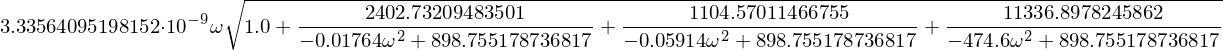

In [124]:
dispersion_difference_function.expand()

In [125]:
update_expression = make_newton_update_expression(dispersion_difference_function.expand(),symbols=[omega])

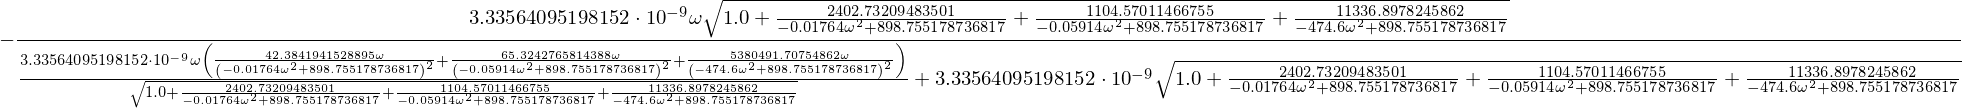

In [128]:
update_expression[0]

In [129]:
newton_update_func = ufuncify( [omega] , update_expression)

In [130]:
newton_update_func(10)

In [20]:
t0 = time.clock()
for i in xrange(int(1e7)):
    newton_update_func(10.)
t1 = time.clock()
print t1-t0

7.69149


In [21]:
#####

In [22]:
dispersion_difference_function = k_symb(omega1,pol='o')+k_symb(omega2,pol='o')+k_symb(omega3,pol='e')

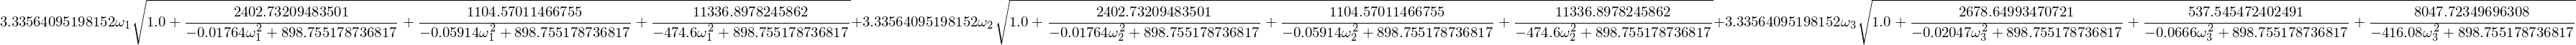

In [23]:
dispersion_difference_function.expand()*1e9

In [24]:
def make_newton_update_expression(dispersion_difference_function,symbols):
    expression_diff = np.asarray([sp.diff(dispersion_difference_function,sym) for sym in symbols])
    return np.array(([sym - dispersion_difference_function / der for sym,der in zip(symbols,expression_diff)]))

In [25]:
update_expression = make_newton_update_expression((1e9*dispersion_difference_function).expand(),
                                                    symbols=[omega1,omega2,omega3])

In [26]:
update_expression = np.asarray([ex.subs(omega3,-omega1-omega2) for ex in update_expression])

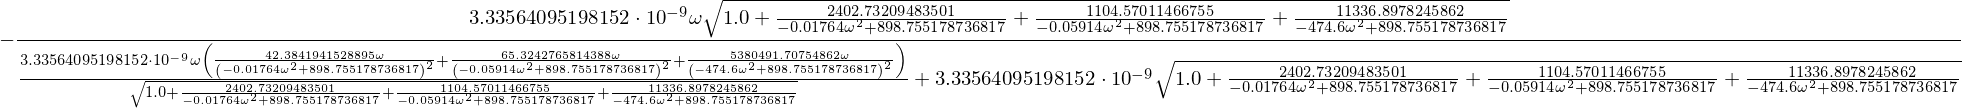

In [131]:
update_expression[0]

In [28]:
symbols=[omega1,omega2]

newton_update_func_0 = ufuncify( symbols , update_expression[0])
newton_update_func_1 = ufuncify( symbols , update_expression[1])
newton_update_func_2 = ufuncify( symbols , update_expression[2])

# Notes

There are three frequencies, $\omega_1,\omega_2,\omega_3$. By the frequency matching condition, we impose $\omega_3 = -\omega_1 - \omega_2$. 

The user must be watchful of the range for which the index of refraction equation is valid. In our case this corresponds to $\omega \in \pm [6,60]$ in units of $10^{13} Hz$. 

In the above code, `fixed_omega1 is the value` dedicated to a fixed value of $\omega_1$. There is a single degree of freedom remaining since $\omega_3$ depends on $\omega_1,\omega_2$. We initialize a list of tuples `oms` with the values that will correspond to the initial values of $\omega_1$ and $\omega_2$. We must make sure that all three values are inside the admissible range. When the values are in the 'corners' of the ranges, Newton's method convergence slows.

In [135]:
omegas = np.asarray([6.+ i*5e-1 for i in range(120)])

In [136]:
k_os = [k_symb(pol='o').subs(omega,om) for om in omegas]
k_es = [k_symb(pol='e').subs(omega,om) for om in omegas]

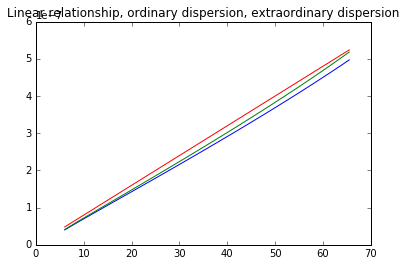

In [137]:
plt.plot(omegas,k_es)
plt.plot(omegas,k_os)
plt.plot(omegas,omegas*8e-9)
plt.title('Linear relationship, ordinary dispersion, extraordinary dispersion')

In [138]:
omegas_delta = omegas[1]-omegas[0]

In [139]:
fixed_omega1=15.
oms = [(fixed_omega1, 30 - fixed_omega1)]  ## k is accurate for omega inputs between 6-60.
converged_points = []
for i in range(100):
    arg2 = newton_update_func_1(*(oms[-1]))
    oms.append((omegas[0],arg2))
    if sum([ (oms[-1][i] - oms[-2][i])**2 for i in range(2)]) < omegas_delta / 100.:
        break
for arg1 in omegas:
    for i in range(10):
        arg2 = newton_update_func_1(*(oms[-1]))
        oms.append((arg1,arg2))
        if sum([ (oms[-1][i] - oms[-2][i])**2 for i in range(2)]) < omegas_delta / 100.:
            break
    converged_points.append((arg1,arg2))

In [140]:
converged_omegas = [(arg1,arg2,30-arg1-arg2) for arg1,arg2 in converged_points]

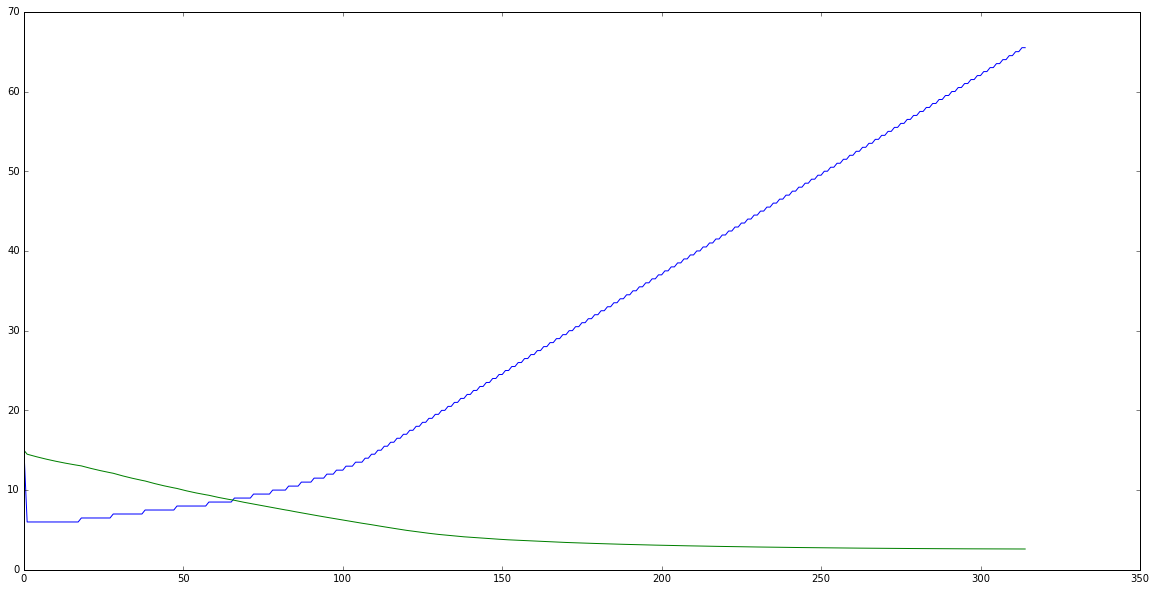

In [141]:
plt.figure(figsize=(20,10))
plt.plot(oms)

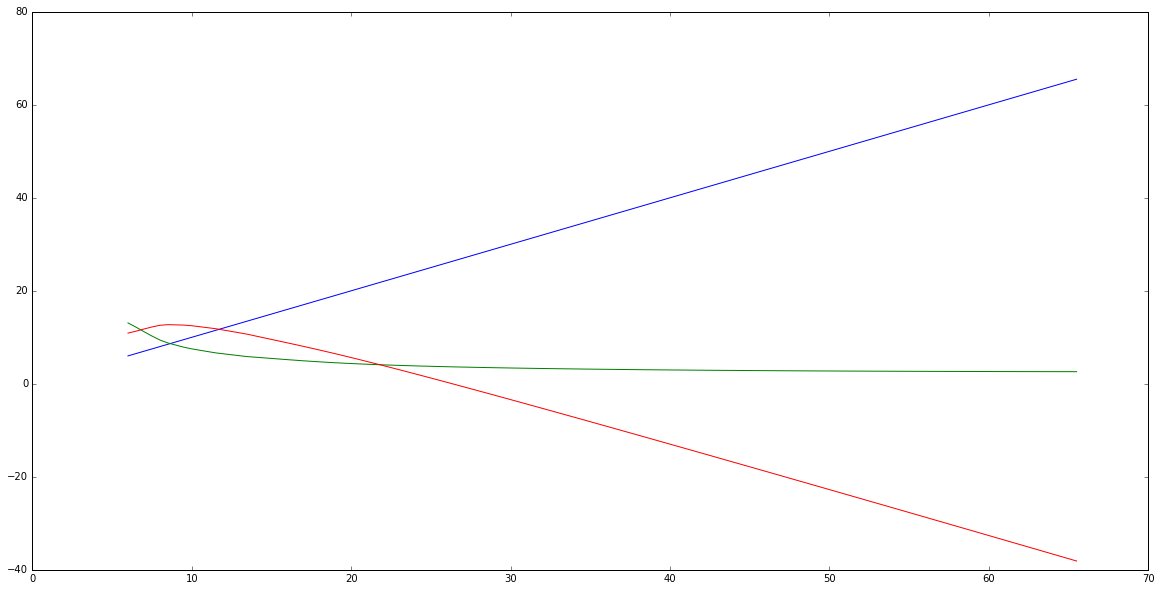

In [142]:
plt.figure(figsize=(20,10))
plt.plot(omegas,converged_omegas)

In [143]:
#####  More omegas

In [41]:
k_o_func = ufuncify([omega],k_symb(pol='o'))
k_e_func = ufuncify([omega],k_symb(pol='e'))

In [147]:
omegas1 = np.asarray([6.+ i*5 for i in range(int(1e1))])
omegas2 = np.asarray([6.+ i*5e-1 for i in range(int(1e2))])
omegas3 = np.asarray([6.+ i*5e-2 for i in range(int(1e3))])
omegas4 = np.asarray([6.+ i*5e-3 for i in range(int(1e4))])
omegas5 = np.asarray([6.+ i*5e-4 for i in range(int(1e5))])

In [148]:
###### Stuff we can do with newton_update_func

In [149]:
fixed_omega1 = 15.
fixed_omega_3 = 30.

In [150]:
omega_pairs = {}
X = {}

In [151]:
for i in range(1,6):
    X[i] = np.arange(7,45,5*pow(10,-i))
    omega_pairs[i] = [(fixed_omega1, omega_2) for omega_2 in X[i]]

In [152]:
@timeit
def get_newton_steps(omega_pairs):
    return map(lambda z: newton_update_func_1(*z),omega_pairs)

In [153]:
newton_out = {}

In [154]:
for i in range(1,6):
    newton_out[i] = get_newton_steps(omega_pairs[i])

'get_newton_steps' 0.00 sec
'get_newton_steps' 0.00 sec
'get_newton_steps' 0.01 sec
'get_newton_steps' 0.08 sec
'get_newton_steps' 0.82 sec


In [55]:
#######

In [56]:
def trace_omegas_BENCHMARK(omegas,fixed_omega_3 = 30.):
    '''
    Trace through triples of frequencies constrained by 
    :math:`omega1+omega2+omega3 = 0`.
    
    At each step of incrementing omega1, find the new omega2 
    and omega3 by applying Newton's method to omega2 
    and the constraint to obtain omega3.
    
    At each step apply 200 Newton's steps to converge.
    
    Args:
        omegas (list of floats):
            The frequencies in the range desired
        fixed_omega_3 (optional [float]): initial value of omega3.
        
    Returns:
        oms (list of floats): A history of the Newton's steps
        converged_points (list of tuples): 
    '''
    fixed_omega1=omegas[0]
    oms = [(fixed_omega1, fixed_omega_3 - fixed_omega1)]  ## k is accurate for omega inputs between 6-60.
    converged_points = []
    for i in range(int(1e5)):
        arg2 = newton_update_func_1(*(oms[-1]))
        oms.append((omegas[0],arg2))
        if sum([ (oms[-1][i] - oms[-2][i])**2 for i in range(2)]) < omegas_delta * 1e-10 :
            break
    for arg1 in omegas:
        for i in range(200):
            arg2 = newton_update_func_1(*(oms[-1]))
            oms.append((arg1,arg2))
        converged_points.append((arg1,arg2))
    return oms,converged_points

In [57]:
def trace_omegas(omegas,fixed_omega_3 = 30.):
    '''
    Trace through triples of frequencies constrained by 
    :math:`omega1+omega2+omega3 = 0`.
    
    At each step of incrementing omega1, find the new omega2 
    and omega3 by applying Newton's method to omega2 
    and the constraint to obtain omega3.
    
    
    Trace through the omegas, when finding the next
    step with Newton's method occasionally check the error 
    and allow terminating early.
    
    Args:
        omegas (list of floats):
            The frequencies in the range desired
        fixed_omega_3 (optional [float]): initial value of omega3.
        
    Returns:
        oms (list of floats): A history of the Newton's steps
        converged_points (list of tuples): 
    '''
    fixed_omega1=omegas[0]
    oms = [(fixed_omega1, fixed_omega_3 - fixed_omega1)]  ## k is accurate for omega inputs between 6-60.
    converged_points = []
    for i in range(int(1e5)):
        arg2 = newton_update_func_1(*(oms[-1]))
        oms.append((omegas[0],arg2))
        if sum([ (oms[-1][i] - oms[-2][i])**2 for i in range(2)]) < omegas_delta * 1e-10 :
            break
    for arg1 in omegas:
        for i in range(50):
            for j in range(10):
                arg2 = newton_update_func_1(*(oms[-1]))
                oms.append((arg1,arg2))
            if sum([ (oms[-1][k] - oms[-2][k])**2 for k in range(2)]) < omegas_delta * 1e-10:
                break
        converged_points.append((arg1,arg2))
    return oms,converged_points

In [58]:
converged_dict = {}
converged_dict_BENCHMARK = {}

In [59]:
for ind,omegas in zip([3,4,5],[omegas3,omegas4,omegas5]):
    t0 = time.clock()
    oms,converged_points = trace_omegas(omegas)
    t1 = time.clock()
    print "time to converge: ", t1-t0
    k_os = k_o_func(omegas)
    k_es = k_e_func(omegas)
    converged_omegas = [(arg1,arg2,30-arg1-arg2) for arg1,arg2 in converged_points]
    converged_dict[ind] = omegas,converged_omegas

time to converge:  0.087337
time to converge:  0.501434
time to converge:  3.071447


In [60]:
for ind,omegas in zip([3,4,5],[omegas3,omegas4,omegas5]):
    t0 = time.clock()
    oms,converged_points = trace_omegas_BENCHMARK(omegas)
    t1 = time.clock()
    print "time to converge: ", t1-t0
    k_os = k_o_func(omegas)
    k_es = k_e_func(omegas)
    converged_omegas_BENCHMARK = [(arg1,arg2,30-arg1-arg2) for arg1,arg2 in converged_points]
    converged_dict_BENCHMARK[ind] = omegas,converged_omegas_BENCHMARK

time to converge:  0.37857
time to converge:  2.663485
time to converge:  26.749138


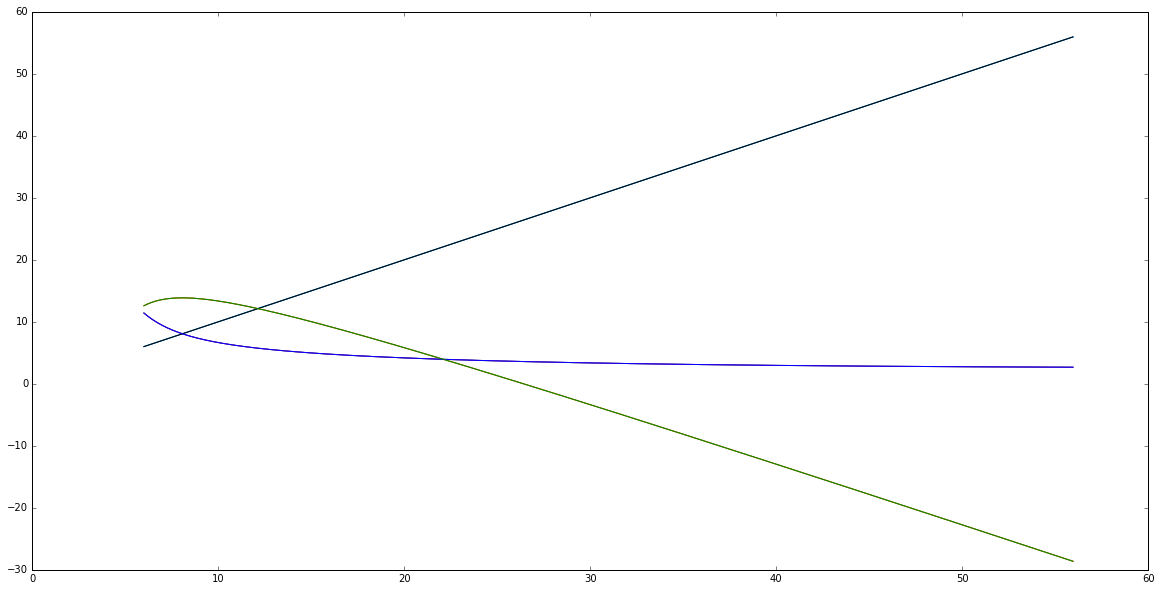

In [61]:
plt.figure(figsize=(20,10))
for ind,(omegas,converged_omegas) in converged_dict.iteritems():
    #plt.figure(ind)
    plt.plot(omegas[::pow(10,ind-3)],converged_omegas[::pow(10,ind-3)])

In [62]:
omegas_converged = {}

In [63]:
for i in range(3,6):
    omegas,converged_omegas = converged_dict[i]
    omegas_converged[i] =  [tup[1] for tup in converged_omegas]

## Interpolations 

Note: Using UnivariateSpline with k=2 and a small value of `s` seems to offer a good balance of speed and precision.

In [157]:
@timeit
def interpolate_omegas(omegas_few,omegas_many,omegas_few_values):
    '''
    A method for interpolation from omegas_few to omegas_many.
    
    Args:
        omegas_few (list of floats):
            points to use to interpolate
        omegas_many (list of floats):
            points to interpolate to. Should have omegas_few included.
        omegas_few_values (list of floats):
            The values of the omegas_few that have already been computed
            
    Returns:
        A list of length len(omegas_many) interpolating the values of omegas_few.
    '''
    f = interpolate.UnivariateSpline(omegas_few, omegas_few_values,k=2,s=1e-10)
    return f(omegas_many)

In [158]:
omega_values_interpolated = interpolate_omegas(np.asarray(omegas3),np.asarray(omegas5[1:99900]),np.asarray(omegas_converged[3]))

'interpolate_omegas' 0.03 sec


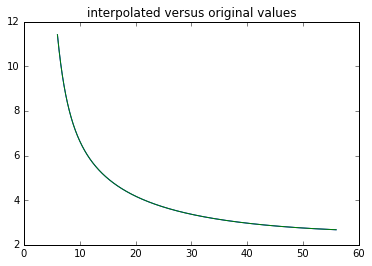

In [159]:
plt.plot(omegas5[1:99900],omega_values_interpolated)
plt.plot(omegas3,omegas_converged[3])
plt.title('interpolated versus original values')

In [161]:
print 'total abs error', sum(abs(omega_values_interpolated - np.asarray(omegas_converged[5][1:99900])))
print 'max error', max(abs(omega_values_interpolated - np.asarray(omegas_converged[5][1:99900])))

total abs error 0.520267025544
max error 7.03401227735e-05


##  Experimenting with 2D interpolation (could be used for four-wave mixing)

We try to use 2-D cubic interpolation from a grid of length 1001 to a grid of length 10001. Time is 3.67 sec.

In [68]:
omegas_dict = {}

In [69]:
for i in range(3,6):
    omegas_dict[i] = [6.+ j*5*pow(10,-i) for j in range(1+pow(10,i))]

In [70]:
print np.asarray(omegas_dict[5])

[  6.        6.00005   6.0001  ...,  10.9999   10.99995  11.     ]


In [162]:
print np.asarray(omegas_dict[3])

[  6.      6.005   6.01  ...,  10.99   10.995  11.   ]


In [168]:
x = omegas_dict[3]
y = omegas_dict[3]

In [169]:
len(x)

In [73]:
z = np.zeros((len(x),len(y)))

In [74]:
for i in xrange(len(x)):
    for j in xrange(len(y)):
        z[i,j] = x[i]+y[j]

In [75]:
f = interpolate.interp2d(x,y,z,kind='q')

In [163]:
x_new = omegas_dict[4]
y_new = omegas_dict[4]

In [167]:
len(x_new)

In [164]:
@timeit
def get_values(x_new,y_new):
    return f(x_new,y_new)

In [165]:
z = get_values(x_new,y_new)

'get_values' 3.67 sec
